In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import random, os, gc
from scipy import sparse
from sklearn.metrics import average_precision_score
from xgboost import DMatrix
import xgboost as xgb
from dask.distributed import Client

from src.modules.transformation import descriptors

In [2]:
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) 
    
seed_everything(42)

def fold_properties(df):
    print('Shape :',df.shape)
    print('block1 :',df.buildingblock1_smiles.nunique())
    print('block2 :',df.buildingblock2_smiles.nunique())
    print('block3 :',df.buildingblock3_smiles.nunique())    
    for target in TARGETS:
        print(f'Positive Cases Ratio for {target} :', target,(df[target].sum()/df.shape[0]))

In [3]:
from pathlib import Path

TARGETS=['binds_BRD4','binds_HSA','binds_sEH']
dtypes = {'buildingblock1_smiles': np.int16, 'buildingblock2_smiles': np.int16, 'buildingblock3_smiles': np.int16,
          'binds_BRD4':np.byte, 'binds_HSA':np.byte, 'binds_sEH':np.byte}


directory = Path("../data/shrunken/")
train = pd.read_parquet(directory / "train.parquet")

In [4]:
BBs_dict_reverse_1 = pickle.load(open(directory / 'train_dicts/BBs_dict_reverse_1.p', 'br'))
BBs_dict_reverse_2 = pickle.load(open(directory / 'train_dicts/BBs_dict_reverse_2.p', 'br'))
BBs_dict_reverse_3 = pickle.load(open(directory / 'train_dicts/BBs_dict_reverse_3.p', 'br'))

train_df = train[(train.binds_BRD4 == 1) | (train.binds_HSA == 1) | (train.binds_sEH == 1)].sample(n=2000)
train_df = pd.concat([train_df, train[(train.binds_BRD4 == 0) & (train.binds_HSA == 0) & (train.binds_sEH == 0)].sample(n=8000)])
train_df.reset_index(drop=True, inplace=True)

train_df['buildingblock1_smiles'] = train_df['buildingblock1_smiles'].map(BBs_dict_reverse_1)
train_df['buildingblock2_smiles'] = train_df['buildingblock2_smiles'].map(BBs_dict_reverse_2)
train_df['buildingblock3_smiles'] = train_df['buildingblock3_smiles'].map(BBs_dict_reverse_3)

In [5]:
train_df.head()

,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,binds_BRD4,binds_HSA,binds_sEH
0,O=C(NC[C@H]1CC[C@H](C(=O)O)CC1)OCC1c2ccccc2-c2...,Cl.Cl.NCc1cn2cc(Br)ccc2n1,C[Si](C)(C)C#Cc1ccc(N)cn1,C[Si](C)(C)C#Cc1ccc(Nc2nc(NCc3cn4cc(Br)ccc4n3)...,0,0,1
1,O=C(NC1(C(=O)O)CCCCC1)OCC1c2ccccc2-c2ccccc21,CC(C)(C#N)c1ccc(N)cc1,Cl.NCCS(=O)(=O)Nc1ccccc1,CC(C)(C#N)c1ccc(Nc2nc(NCCS(=O)(=O)Nc3ccccc3)nc...,1,0,0
2,O=C(NC(Cc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,COc1ccc(N)cc1OC,Nc1n[nH]c2c(F)c(F)ccc12,COc1ccc(Nc2nc(Nc3n[nH]c4c(F)c(F)ccc34)nc(NC(Cc...,1,0,0
3,N#Cc1ccc(C[C@H](CC(=O)O)NC(=O)OCC2c3ccccc3-c3c...,Nc1ccc2ncccc2c1,NCc1ccc(CN2CCCC2=O)cc1,N#Cc1ccc(C[C@H](CC(=O)N[Dy])Nc2nc(NCc3ccc(CN4C...,1,0,0
4,O=C(O)C[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)c1c...,CC(=O)SCCN.Cl,N#Cc1cnn(-c2ccccc2)c1N,CC(=O)SCCNc1nc(Nc2c(C#N)cnn2-c2ccccc2)nc(N[C@H...,1,0,0


In [6]:
client = Client()

In [11]:
from rdkit.Chem import Descriptors
from rdkit import Chem

desc_names = [
        "MaxAbsEStateIndex",
        "MaxAbsEStateIndex",
        "MinAbsEStateIndex",
        "MinEStateIndex",
        "qed",
        "SPS",
        "MolWt",
        "HeavyAtomMolWt",
        "ExactMolWt",
        "NumValenceElectrons",
        "MaxPartialCharge",
        "MinPartialCharge",
        "MaxAbsPartialCharge",
        "MinAbsPartialCharge",
        "FpDensityMorgan1",
        "FpDensityMorgan2",
        "FpDensityMorgan3",
        "BCUT2D_MWHI",
        "BCUT2D_MWLOW",
        "BCUT2D_CHGHI",
        "BCUT2D_CHGLO",
        "BCUT2D_LOGPHI",
        "BCUT2D_LOGPLOW",
        "BCUT2D_MRHI",
        "BCUT2D_MRLOW",
        "AvgIpc",
        "BalabanJ",
        "BertzCT",
        "Chi0",
        "Chi0n",
        "Chi0v",
        "HallKierAlpha",
        "Ipc",
        "LabuteASA",
        "PEOE_VSA1",
        "SMR_VSA1",
        "SlogP_VSA1",
        "TPSA",
        "EState_VSA1",
        "VSA_EState1",
        "FractionCSP3",
        "MolLogP",
        "MolMR",
    ]

desc_list = {desc_name: getattr(Descriptors, desc_name) for desc_name in desc_names}

def calculate_single_descriptor(smiles, desc_func):
    mol = Chem.MolFromSmiles(smiles)
    desc_value = desc_func(mol)
    return desc_value

In [12]:
for name, func in desc_list.items():
    assert callable(func), f"The function {name} is not callable!"

In [13]:
for name, desc_func in desc_list.items():
    train_df[name] = train_df['molecule_smiles'].map(lambda smiles: calculate_single_descriptor(smiles, desc_func))

In [14]:
train_df.head()

,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,binds_BRD4,binds_HSA,binds_sEH,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,...,LabuteASA,PEOE_VSA1,SMR_VSA1,SlogP_VSA1,TPSA,EState_VSA1,VSA_EState1,FractionCSP3,MolLogP,MolMR
0,O=C(NC[C@H]1CC[C@H](C(=O)O)CC1)OCC1c2ccccc2-c2...,Cl.Cl.NCc1cn2cc(Br)ccc2n1,C[Si](C)(C)C#Cc1ccc(N)cn1,C[Si](C)(C)C#Cc1ccc(Nc2nc(NCc3cn4cc(Br)ccc4n3)...,0,0,1,12.006485,0.097007,-1.486927,...,285.208955,4.400695,41.373821,17.698138,134.05,8.073872,5.697630,0.379310,5.06020,169.8698
1,O=C(NC1(C(=O)O)CCCCC1)OCC1c2ccccc2-c2ccccc21,CC(C)(C#N)c1ccc(N)cc1,Cl.NCCS(=O)(=O)Nc1ccccc1,CC(C)(C#N)c1ccc(Nc2nc(NCCS(=O)(=O)Nc3ccccc3)nc...,1,0,0,12.944627,0.030227,-3.630702,...,270.742014,0.000000,49.791618,22.420232,173.82,20.977207,30.483390,0.392857,3.96548,158.1133
2,O=C(NC(Cc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,COc1ccc(N)cc1OC,Nc1n[nH]c2c(F)c(F)ccc12,COc1ccc(Nc2nc(Nc3n[nH]c4c(F)c(F)ccc34)nc(NC(Cc...,1,0,0,14.275539,0.015836,-1.059738,...,262.819272,4.736863,59.628377,27.171864,151.00,17.676283,41.315591,0.148148,4.13420,147.6475
3,N#Cc1ccc(C[C@H](CC(=O)O)NC(=O)OCC2c3ccccc3-c3c...,Nc1ccc2ncccc2c1,NCc1ccc(CN2CCCC2=O)cc1,N#Cc1ccc(C[C@H](CC(=O)N[Dy])Nc2nc(NCc3ccc(CN4C...,1,0,0,12.477666,0.142702,-0.349109,...,302.581254,4.899910,46.168358,17.698138,160.85,0.000000,2.667730,0.228571,4.76338,178.3038
4,O=C(O)C[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)c1c...,CC(=O)SCCN.Cl,N#Cc1cnn(-c2ccccc2)c1N,CC(=O)SCCNc1nc(Nc2c(C#N)cnn2-c2ccccc2)nc(N[C@H...,1,0,0,12.223817,0.016429,-0.387931,...,257.201819,0.000000,46.168358,17.698138,162.54,0.000000,4.212026,0.208333,3.54948,146.4598


In [15]:
train_df_desc = train_df.drop(['molecule_smiles', 'buildingblock1_smiles', 'buildingblock2_smiles', 'buildingblock3_smiles'], axis=1)

In [16]:
train_df_desc.dropna(inplace=True)

# Check for Inf values
print("Contains Inf:", np.isinf(train_df_desc).any())

Contains Inf: binds_BRD4             False
binds_HSA              False
binds_sEH              False
MaxAbsEStateIndex      False
MinAbsEStateIndex      False
MinEStateIndex         False
qed                    False
SPS                    False
MolWt                  False
HeavyAtomMolWt         False
ExactMolWt             False
NumValenceElectrons    False
MaxPartialCharge       False
MinPartialCharge       False
MaxAbsPartialCharge    False
MinAbsPartialCharge    False
FpDensityMorgan1       False
FpDensityMorgan2       False
FpDensityMorgan3       False
BCUT2D_MWHI            False
BCUT2D_MWLOW           False
BCUT2D_CHGHI           False
BCUT2D_CHGLO           False
BCUT2D_LOGPHI          False
BCUT2D_LOGPLOW         False
BCUT2D_MRHI            False
BCUT2D_MRLOW           False
AvgIpc                 False
BalabanJ               False
BertzCT                False
Chi0                   False
Chi0n                  False
Chi0v                  False
HallKierAlpha          False


In [73]:
# Clean infinite values
infinite_columns = ['MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge']

train_df_desc[infinite_columns] = train_df_desc[infinite_columns].replace([np.inf, -np.inf], np.nan)

train_df_desc.dropna(inplace=True)

In [74]:
from sklearn.ensemble import RandomForestRegressor

model_BRD4 = RandomForestRegressor(n_estimators=100, random_state=42)
model_BRD4.fit(train_df_desc.drop(['binds_BRD4', 'binds_HSA', 'binds_sEH'], axis = 1), train_df_desc['binds_BRD4'])

RandomForestRegressor(random_state=42)

In [75]:
model_HSA = RandomForestRegressor(n_estimators=100, random_state=42)
model_HSA.fit(train_df_desc.drop(['binds_BRD4', 'binds_HSA', 'binds_sEH'], axis = 1), train_df_desc['binds_HSA'])

model_sEH = RandomForestRegressor(n_estimators=100, random_state=42)
model_sEH.fit(train_df_desc.drop(['binds_BRD4', 'binds_HSA', 'binds_sEH'], axis = 1), train_df_desc['binds_sEH'])

RandomForestRegressor(random_state=42)

In [57]:
feature_importances_BRD4 = model_BRD4.feature_importances_
feature_importances_HSA = model_HSA.feature_importances_
feature_importances_sEH= model_sEH.feature_importances_

In [76]:
from matplotlib import pyplot as plt

features_BRD4 = train_df_desc.drop(['binds_BRD4', 'binds_HSA', 'binds_sEH'], axis=1).columns
indices_BRD4 = np.argsort(feature_importances_BRD4)[::-1]
sorted_feature_names_BRD4 = [features_BRD4[i] for i in indices_BRD4]

features_HSA = train_df_desc.drop(['binds_BRD4', 'binds_HSA', 'binds_sEH'], axis=1).columns
indices_HSA = np.argsort(feature_importances_HSA)[::-1]
sorted_feature_names_HSA = [features_BRD4[i] for i in indices_HSA]

features_sEH = train_df_desc.drop(['binds_BRD4', 'binds_HSA', 'binds_sEH'], axis=1).columns
indices_sEH = np.argsort(feature_importances_sEH)[::-1]
sorted_feature_names_sEH = [features_BRD4[i] for i in indices_sEH]


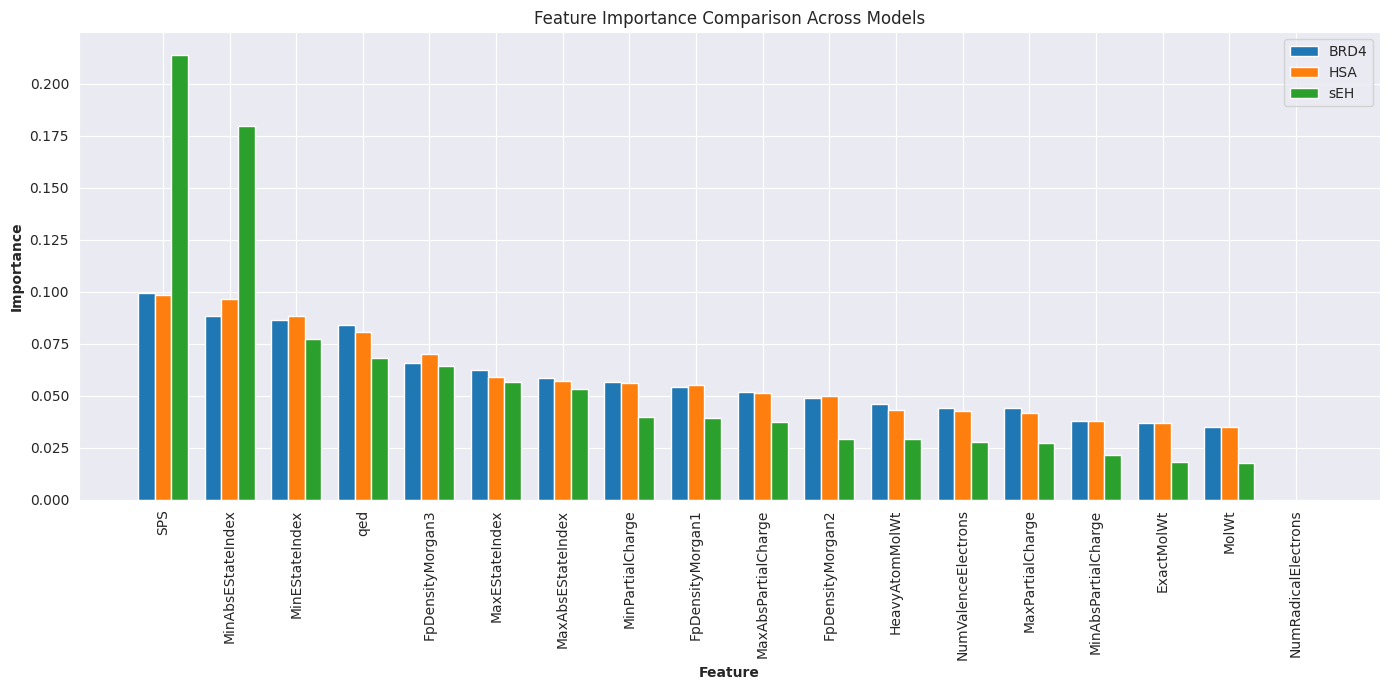

In [77]:
plt.figure(figsize=(14, 7))
n_features = len(features_BRD4) 
bar_width = 0.25
index = np.arange(n_features)

plt.bar(index, feature_importances_BRD4[indices_BRD4], bar_width, label='BRD4')
plt.bar(index + bar_width, feature_importances_HSA[indices_HSA], bar_width, label='HSA')
plt.bar(index + 2 * bar_width, feature_importances_sEH[indices_sEH], bar_width, label='sEH')

plt.xlabel('Feature', fontweight='bold')
plt.ylabel('Importance', fontweight='bold')
plt.title('Feature Importance Comparison Across Models')
plt.xticks(index + bar_width, sorted_feature_names_BRD4, rotation=90)  # Use BRD4 names as reference

# Create legend & Show graphic
plt.legend()
plt.tight_layout()
plt.show()

### Evaluate based on building blocks

In [128]:
train_df.shape

(10000, 7)

In [62]:
new_df = train_df.copy()

new_df['concatenated_smiles'] = new_df['buildingblock1_smiles'].str.cat(new_df[['buildingblock2_smiles', 'buildingblock3_smiles']], sep='')

# for name, desc in desc_list.items():
#     new_df[name] = new_df['concatenated_smiles'].map(lambda x : calculate_single_descriptor(x, desc))

In [63]:
 new_df.head()

,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,binds_BRD4,binds_HSA,binds_sEH,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,...,PEOE_VSA1,SMR_VSA1,SlogP_VSA1,TPSA,EState_VSA1,VSA_EState1,FractionCSP3,MolLogP,MolMR,concatenated_smiles
0,O=C(NC[C@H]1CC[C@H](C(=O)O)CC1)OCC1c2ccccc2-c2...,Cl.Cl.NCc1cn2cc(Br)ccc2n1,C[Si](C)(C)C#Cc1ccc(N)cn1,C[Si](C)(C)C#Cc1ccc(Nc2nc(NCc3cn4cc(Br)ccc4n3)...,0,0,1,12.006485,0.097007,-1.486927,...,4.400695,41.373821,17.698138,134.05,8.073872,5.697630,0.379310,5.06020,169.8698,O=C(NC[C@H]1CC[C@H](C(=O)O)CC1)OCC1c2ccccc2-c2...
1,O=C(NC1(C(=O)O)CCCCC1)OCC1c2ccccc2-c2ccccc21,CC(C)(C#N)c1ccc(N)cc1,Cl.NCCS(=O)(=O)Nc1ccccc1,CC(C)(C#N)c1ccc(Nc2nc(NCCS(=O)(=O)Nc3ccccc3)nc...,1,0,0,12.944627,0.030227,-3.630702,...,0.000000,49.791618,22.420232,173.82,20.977207,30.483390,0.392857,3.96548,158.1133,O=C(NC1(C(=O)O)CCCCC1)OCC1c2ccccc2-c2ccccc21CC...
2,O=C(NC(Cc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,COc1ccc(N)cc1OC,Nc1n[nH]c2c(F)c(F)ccc12,COc1ccc(Nc2nc(Nc3n[nH]c4c(F)c(F)ccc34)nc(NC(Cc...,1,0,0,14.275539,0.015836,-1.059738,...,4.736863,59.628377,27.171864,151.00,17.676283,41.315591,0.148148,4.13420,147.6475,O=C(NC(Cc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21...
3,N#Cc1ccc(C[C@H](CC(=O)O)NC(=O)OCC2c3ccccc3-c3c...,Nc1ccc2ncccc2c1,NCc1ccc(CN2CCCC2=O)cc1,N#Cc1ccc(C[C@H](CC(=O)N[Dy])Nc2nc(NCc3ccc(CN4C...,1,0,0,12.477666,0.142702,-0.349109,...,4.899910,46.168358,17.698138,160.85,0.000000,2.667730,0.228571,4.76338,178.3038,N#Cc1ccc(C[C@H](CC(=O)O)NC(=O)OCC2c3ccccc3-c3c...
4,O=C(O)C[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)c1c...,CC(=O)SCCN.Cl,N#Cc1cnn(-c2ccccc2)c1N,CC(=O)SCCNc1nc(Nc2c(C#N)cnn2-c2ccccc2)nc(N[C@H...,1,0,0,12.223817,0.016429,-0.387931,...,0.000000,46.168358,17.698138,162.54,0.000000,4.212026,0.208333,3.54948,146.4598,O=C(O)C[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)c1c...


In [64]:
new_df.head()

new_df.drop(['buildingblock1_smiles', 'buildingblock2_smiles', 'buildingblock3_smiles', 'molecule_smiles', 'concatenated_smiles'], axis = 1,  inplace = True)
# Check for Inf values
print("Contains Inf:", np.isinf(new_df).any())

Contains Inf: binds_BRD4             False
binds_HSA              False
binds_sEH              False
MaxAbsEStateIndex      False
MinAbsEStateIndex      False
MinEStateIndex         False
qed                    False
SPS                    False
MolWt                  False
HeavyAtomMolWt         False
ExactMolWt             False
NumValenceElectrons    False
MaxPartialCharge        True
MinPartialCharge        True
MaxAbsPartialCharge     True
MinAbsPartialCharge     True
FpDensityMorgan1       False
FpDensityMorgan2       False
FpDensityMorgan3       False
BCUT2D_MWHI            False
BCUT2D_MWLOW           False
BCUT2D_CHGHI           False
BCUT2D_CHGLO           False
BCUT2D_LOGPHI          False
BCUT2D_LOGPLOW         False
BCUT2D_MRHI            False
BCUT2D_MRLOW           False
AvgIpc                 False
BalabanJ               False
BertzCT                False
Chi0                   False
Chi0n                  False
Chi0v                  False
HallKierAlpha          False


In [67]:
new_df[infinite_columns] = new_df[infinite_columns].replace([np.inf, -np.inf], 0)

model_BRD4_b1 = RandomForestRegressor(n_estimators=100, random_state=42)
model_BRD4_b1.fit(new_df.drop(['binds_BRD4', 'binds_HSA', 'binds_sEH'], axis = 1), new_df['binds_BRD4'])

model_HSA_b1 = RandomForestRegressor(n_estimators=100, random_state=42)
model_HSA_b1.fit(new_df.drop(['binds_BRD4', 'binds_HSA', 'binds_sEH'], axis = 1), new_df['binds_HSA'])

model_sEH_b1 = RandomForestRegressor(n_estimators=100, random_state=42)
model_sEH_b1.fit(new_df.drop(['binds_BRD4', 'binds_HSA', 'binds_sEH'], axis = 1), new_df['binds_sEH'])

feature_importances_BRD4 = model_BRD4_b1.feature_importances_
feature_importances_HSA = model_HSA_b1.feature_importances_
feature_importances_sEH= model_sEH_b1.feature_importances_


KeyboardInterrupt: 

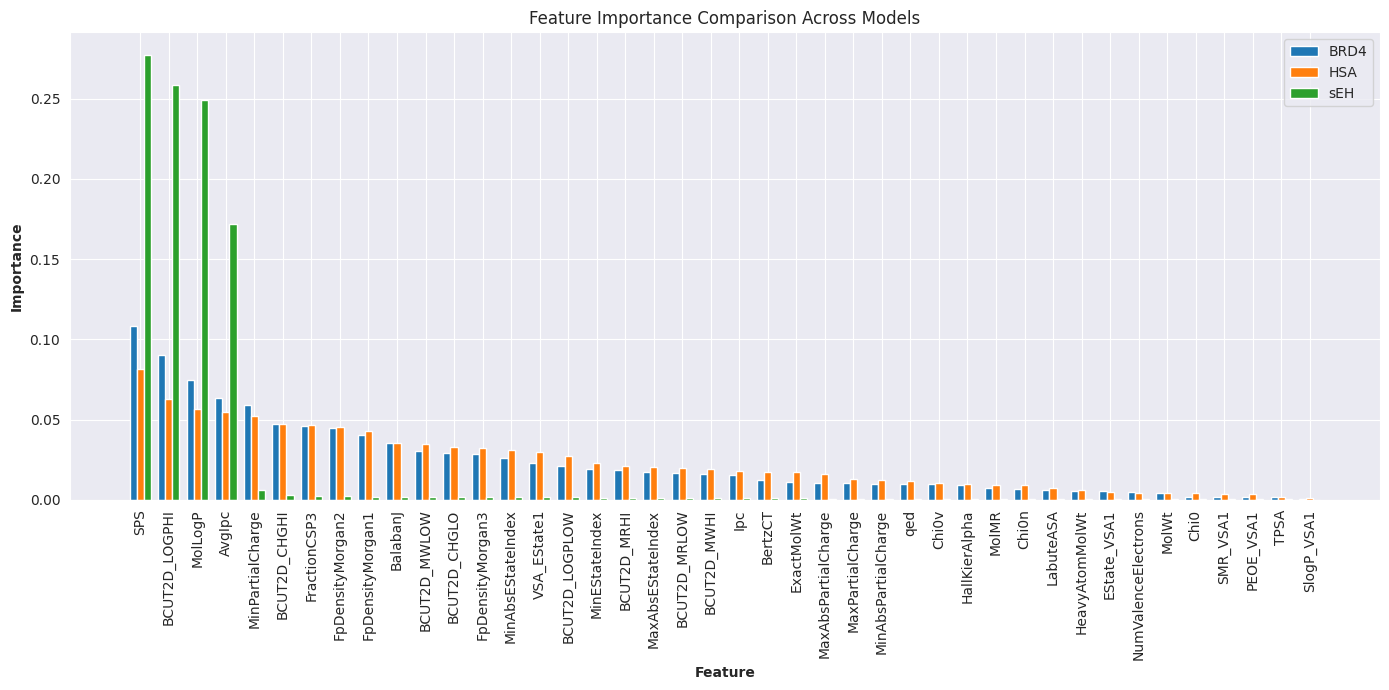

In [124]:
features_BRD4 = new_df.drop(['binds_BRD4', 'binds_HSA', 'binds_sEH'], axis=1).columns
indices_BRD4 = np.argsort(feature_importances_BRD4)[::-1]
sorted_feature_names_BRD4 = [features_BRD4[i] for i in indices_BRD4]

features_HSA = new_df.drop(['binds_BRD4', 'binds_HSA', 'binds_sEH'], axis=1).columns
indices_HSA = np.argsort(feature_importances_HSA)[::-1]
sorted_feature_names_HSA = [features_BRD4[i] for i in indices_HSA]

features_sEH = new_df.drop(['binds_BRD4', 'binds_HSA', 'binds_sEH'], axis=1).columns
indices_sEH = np.argsort(feature_importances_sEH)[::-1]
sorted_feature_names_sEH = [features_BRD4[i] for i in indices_sEH]

plt.figure(figsize=(14, 7))
n_features = len(features_BRD4) 
bar_width = 0.25
index = np.arange(n_features)

plt.bar(index, feature_importances_BRD4[indices_BRD4], bar_width, label='BRD4')
plt.bar(index + bar_width, feature_importances_HSA[indices_HSA], bar_width, label='HSA')
plt.bar(index + 2 * bar_width, feature_importances_sEH[indices_sEH], bar_width, label='sEH')

plt.xlabel('Feature', fontweight='bold')
plt.ylabel('Importance', fontweight='bold')
plt.title('Feature Importance Comparison Across Models')
plt.xticks(index + bar_width, sorted_feature_names_BRD4, rotation=90)  # Use BRD4 names as reference

# Create legend & Show graphic
plt.legend()
plt.tight_layout()
plt.show()

### Comparison Smiles vs BBs    

In [71]:
embed_df = train_df.copy()
embed_df.head()

embed_df['concatenated_smiles'] = embed_df['buildingblock1_smiles'].str.cat(embed_df[['buildingblock2_smiles', 'buildingblock3_smiles']], sep='')

In [ ]:
from transformers import AutoModel, AutoTokenizer
model_name = "seyonec/ChemBERTa-zinc-base-v1"  
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

inputs_mols = tokenizer(embed_df['molecule_smiles'].tolist(), padding=True, truncation=True, return_tensors="pt")
inputs_bbs = tokenizer(embed_df['concatenated_smiles'].tolist(), padding=True, truncation=True, return_tensors="pt")

import torch

with torch.no_grad():
    outputs = model(**inputs_mols)
    embeddings = outputs.last_hidden_state[:, 0, :] 
    outputs_bbs = model(**inputs_bbs)
    embeddings_bbs = outputs_bbs.last_hidden_state[:, 0, :]

embed_df['mol_embeddings'] = embeddings
embed_df['bbs_embeddings'] = embeddings_bbs

/home/daniel-de-dios/PycharmProjects/q4-detect-medicine/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


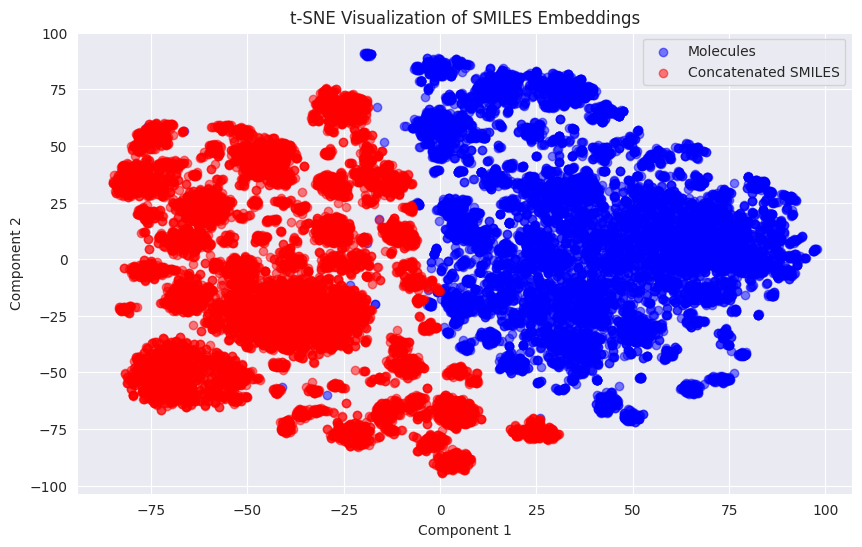

In [141]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

embeddings_mols_np = embeddings.numpy() 
embeddings_bbs_np = embeddings_bbs.numpy()

tsne = TSNE(n_components=2, random_state=42)
all_embeddings = np.vstack((embeddings_mols_np, embeddings_bbs_np))  
all_embeddings_2d = tsne.fit_transform(all_embeddings)

# Split the transformed embeddings
mols_embeddings_2d = all_embeddings_2d[:len(embeddings_mols_np)]
bbs_embeddings_2d = all_embeddings_2d[len(embeddings_mols_np):]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(mols_embeddings_2d[:, 0], mols_embeddings_2d[:, 1], c='blue', label='Molecules', alpha=0.5)
plt.scatter(bbs_embeddings_2d[:, 0], bbs_embeddings_2d[:, 1], c='red', label='Concatenated SMILES', alpha=0.5)
plt.title('t-SNE Visualization of SMILES Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

In [148]:
from sklearn.cluster import KMeans

n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings_bbs_np) 

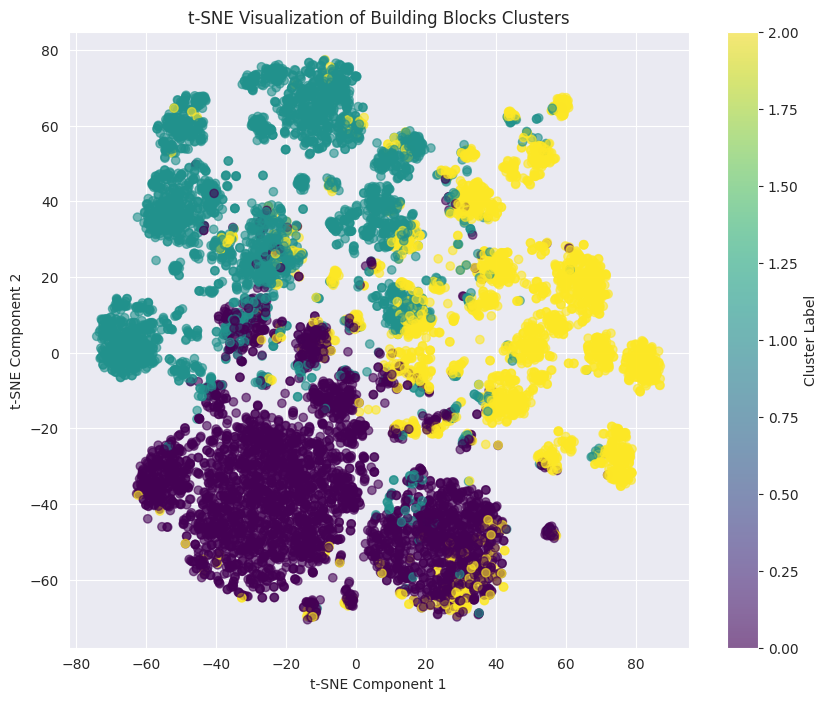

In [149]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_bbs_2d = tsne.fit_transform(embeddings_bbs_np)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_bbs_2d[:, 0], embeddings_bbs_2d[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.title('t-SNE Visualization of Building Blocks Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.show()